# Assignment Week 10: Text Mining using Dimensionality Reduction Methods

## Student ID: XXXXXXXX

This dataset comes from the website [Internet Movie Database](https://www.imdb.com/), and represents 1,000 reviews which were labeled (by humans) as positive or negative, see [here](http://ai.stanford.edu/~amaas/data/sentiment/) for more details. In this coursework, we will study how we can use dimensionality reduction methods to improve our understanding of text data and to predict the sentiment of a set of texts. This application of data science is called [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) and it is widely used across many fields to get automated feedback when text opinions are expressed. While most modern methods of sentiment analysis are using complex deep learning methods, the tools we have seen this week can be readily applied to get a good idea of what our users are expressing.

In [1]:
# Import other packages if you need them!
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn.feature_extraction.text as sktext
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score


# Plotting
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Data import

The dataset comes with the text and a binary variable which represents the sentiment, either positive or negative. The following code imports the data, splits it into train and test, and applies the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) (see the lectures, slide 34).

In [2]:
# Be sure to first leave the data here!
imdb_data = pd.read_excel('IMDB_Sample.xlsx')


# Scikit-Learn works by first defining the der 
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf=True # Use sublinear weights (softplus)
                      )

# Train / test split
x_train, x_test, y_train, y_test = train_test_split(imdb_data['texts'],
                                                    imdb_data['class'],
                                                    test_size=0.3,
                                                    random_state=20210318)

# Calculate the Tf-Idf transform.
TfIDF_train = TfIDFTransformer.fit_transform(x_train)
TfIDF_test = TfIDFTransformer.transform(x_test)

# Turn to dense matrix as PCA does not like sparse ones.
TfIDF_train = TfIDF_train.toarray()
TfIDF_test = TfIDF_test.toarray()

From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required).  The output is a **sparse matrix** with the 236 words that do not appear in more than 95% of texts nor in less than 5% of texts. These matrices only store the relevant information! They are *much* more efficient in-memory.  Sadly, PCA nor torch deal very well with sparse matrices without further processing, so we turn them into dense matrices.

We can check the outputs of the first row with the below code.

In [3]:
print(TfIDF_train[1,:])

[0.         0.         0.         0.         0.         0.16565558
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.24573797 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.17111284 0.
 0.         0.         0.         0.         0.17934085 0.
 0.18989355 0.         0.20293873 0.         0.         0.
 0.         0.         0.15861506 0.         0.28146216 0.15964171
 0.         0.         0.13397591 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.2143442  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.11417021 0.
 0.         0.         0.         0.         0.19858848 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.1750

Each column represents one word and each non-zero value represents the Tf-IDF weight as seen in the lectures. To find out which word is which in the index, you can use the [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [4]:
print('There are %i words in the index.' % len(TfIDFTransformer.get_feature_names()))

There are 236 words in the index.


## Task 1: PCA decomposition of the texts. [35 pts]

Now you have the TfIDF matrix, We can start working on the data. As a first step, we want to explore what some commonly occuring concepts in the text reviews. We can do this using PCA. A PCA transform of the TF-IDF matrix will give you a basis of the text data, each representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic.

1. First, calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts. 

**Written answer: Exactly how many concepts do you need to correctly explain at least 75% of the data? (note we need the exact # of concepts)**  [15 pts]

Text(0, 0.5, 'Cumulative explained variance')

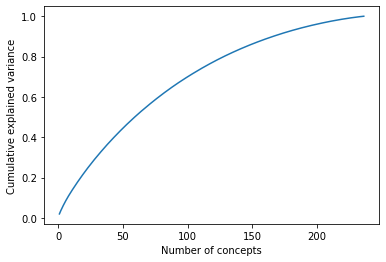

In [5]:
# Your code here.
Q1_PCA = PCA()
Q1_X_train = Q1_PCA.fit_transform(TfIDF_train)
Q1_PCA_VarExp_Incremental = Q1_PCA.explained_variance_ratio_
Q1_PCA_VarExp_CumSum = np.cumsum(Q1_PCA_VarExp_Incremental)
# Make the plot
plt.plot( range(1, 1 + Q1_PCA_VarExp_CumSum.shape[0]), Q1_PCA_VarExp_CumSum )
plt.xlabel("Number of concepts")
plt.ylabel("Cumulative explained variance")

In [6]:
# To get the exact index where the variance is above 75%
print(np.min(np.where(Q1_PCA_VarExp_CumSum > 0.75)) + 1)

114


**Written answer: **114

2. Study the first three concepts. To do this, show the 10 words that are the most important in the each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).

**Written answer: What is the cumulative variance explained by these three concepts? What would you name each of these concepts?** [10 pts]
*Hint: if in a concept you would get the words 'dog', 'cat', 'fish' as the most important ones, you could name the concept 'animals' or 'pets'.*

In [7]:
# Explained variance.
print(np.sum(Q1_PCA_VarExp_Incremental[0:3]))
print(Q1_PCA_VarExp_CumSum[2])

0.04860463896012031
0.04860463896012031


In [8]:
# Get words per component
Q1_FeatureNames = np.array(TfIDFTransformer.get_feature_names())

In [9]:
# Concept 1
Q1_PCA_weight_concept1 = Q1_PCA.components_[0, ]
Q1_PCA_weight_concept1 = np.abs(Q1_PCA_weight_concept1)

Q1_PCA_weight_concept1_idx = np.argpartition(Q1_PCA_weight_concept1, -10)[-10:] 

print(Q1_FeatureNames[Q1_PCA_weight_concept1_idx])

['movie' 'film' 'bad' 'movies' 'films' 'like' 'watch' 'best' 'woman' 'don']


In [10]:
# Concept 2
Q1_PCA_weight_concept2 = Q1_PCA.components_[1, ]
Q1_PCA_weight_concept2 = np.abs(Q1_PCA_weight_concept2)
Q1_PCA_weight_concept2_idx = np.argpartition(Q1_PCA_weight_concept2, -10)[-10:] 

print(Q1_FeatureNames[Q1_PCA_weight_concept2_idx])

['film' 'bad' 'films' 'series' 'way' 'great' 'like' 'story' 'love' 'say']


In [11]:
# Concept 3
Q1_PCA_weight_concept3 = Q1_PCA.components_[2, ]
Q1_PCA_weight_concept3 = np.abs(Q1_PCA_weight_concept3)
Q1_PCA_weight_concept3_idx = np.argpartition(Q1_PCA_weight_concept3, -10)[-10:] 

print(Q1_FeatureNames[Q1_PCA_weight_concept3_idx])

['film' 'movie' 'series' 'man' 'old' 'funny' 'seen' 'star' 'acting' 'new']


**Written answer: **0.04860463896012031,concept1:trash films, concept2:story films, concept3:movie series

3. Apply the PCA transformation to the test dataset. Using only the first two components, make a scatter plot of the cases. Identify positive and negative cases by colouring points with different sentiments with different colours. 

**Written answer: What can you say about where the positive and negative cases lie in your plot? Could we use these concepts to discriminate positive and negative cases? If yes, why? If no, why not? Discuss your findings.** [10 pts]

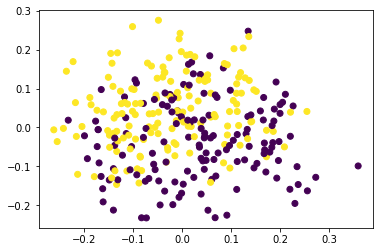

In [12]:
# Apply the test data
Q1_X_test_tranformed = Q1_PCA.transform(TfIDF_test)

# Plot the two different set of points filtering by label.
plt.scatter(Q1_X_test_tranformed[:, 0], Q1_X_test_tranformed[:, 1], c = y_test)

**Written answer:**No, becasue we can see from the plot the points of different colors are overlapped.

## Task 2: Autoencoders [35 pts]

We will see now the ability of autoencoders to compress the data. Train an autoencoder that compresses the data to 60 neurons in the encoding layer as shown in lab 10.2, to be trained over the original TfIDF train dataset. Propose an architecture that uses at least two layers in the encoder and the same number in the decoder. Try at least three variations of your autoencoder, each time trying to reduce model reconstruction error. For each model you train, plot the reconstruction error (MSE) over the train set and the test set as you train every 100 rounds. 

**Written answer: Which of your models performs the best? After how many epochs does your best model reach convergence? Does your model overfit? If yes, why do you think this is? If no, why?** [10 pts each architecture plus 5 pts arguing which one is better plus the explaining of overfitting]

In [26]:
# Model architecture and definition
class autoencoder(nn.Module):
    def __init__(self, n_neurons):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(236,n_neurons),
            nn.Linear(n_neurons, n_neurons),
            nn.Hardtanh(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(n_neurons, n_neurons),
            nn.Linear(n_neurons,236)
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Q2_AutoEncoder = autoencoder(n_neurons = 10)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-1

In [27]:
# Train!
X_scaled = torch.from_numpy(TfIDF_train).float()
X_scaled_test = torch.from_numpy(TfIDF_test).float()
Q2_error_train = []
Q2_error_test = []
max_iter = 5000

for t in range(max_iter):
    y_pred = Q2_AutoEncoder(X_scaled)
    loss = loss_fn(y_pred, X_scaled)
    Q2_AutoEncoder.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in Q2_AutoEncoder.parameters():
            param -= learning_rate * param.grad 
    
    if t % 100 == 0:
        Q2_error_train.append(loss.item())
        
        y_pred = Q2_AutoEncoder(X_scaled_test)
        loss = loss_fn(y_pred, X_scaled_test)
        Q2_error_test.append(loss.item())

0.003772332100197673


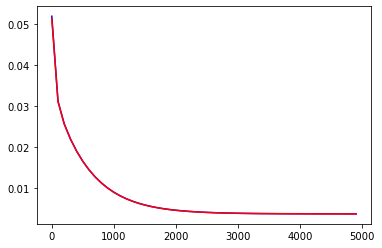

In [29]:
# Plot errors
plt.plot(range(0, max_iter, 100), Q2_error_train, c="blue")
plt.plot(range(0, max_iter, 100), Q2_error_test, c="red")
print(Q2_error_test[-1])

**Written answer:**1500 becomes converge, the model does not overfit, because the red and blue line are pretty close.

## Task 3: Benchmarking predictive capabilities of the compressed data. [30 pts]

For the final task, you will benchmark the different compression algorithms over the original data. For this:

1. Train a regularized logistic regression over the original TfIDF train set (with no compression), and calculate the AUROC over the test set.
2. Train a regularized logistic regression over the PCA-reduced dataset (with 60 components), and calculate the AUROC over the PCA-transformed test set.
3. Train a regularized logistic regression over the encoded dataset (with 60 variables), and calculate AUROC over the encoded test set.

**Written answer 1: Compare the performance of the three models: how do they compare?**

**Written answer 2: Which of the two compression methods (methods 2 and 3) is better at compressing the data without altering its predictive capacity? Why do you think this happens?**

0.8589663760896638

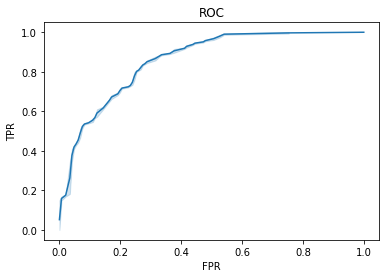

In [30]:
# Full dataset regression and AUC plot / calculation
X_train_full = TfIDF_train
X_test_full = TfIDF_test

Q3_model_full = LogisticRegressionCV(cv=5, max_iter = 10000)
Q3_model_full.fit(X_train_full, y_train)

Q3_ytest_prob_full = Q3_model_full.predict_proba(X_test_full)
Q3_ytest_prob_full = Q3_ytest_prob_full[:, 1] # We only take Pr(Y=1)
fpr, tpr, _ = roc_curve(y_test, Q3_ytest_prob_full)

ax = sns.lineplot(x=fpr,y=tpr)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC")

roc_auc_score(y_test, Q3_ytest_prob_full)

0.8308130225938445

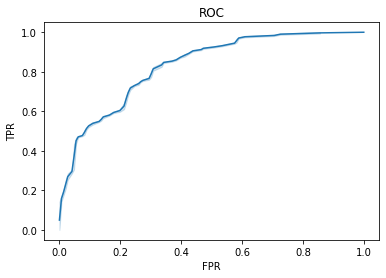

In [31]:
# PCA dataset regression and AUC plot / calculation
Q3_PCA = PCA(n_components = 60)

X_train_PCA = Q3_PCA.fit_transform(TfIDF_train)
X_test_PCA = Q3_PCA.transform(TfIDF_test)

Q3_model_PCA = LogisticRegressionCV(cv=5, max_iter = 10000)
Q3_model_PCA.fit(X_train_PCA, y_train)

Q3_ytest_prob_PCA = Q3_model_PCA.predict_proba(X_test_PCA)
Q3_ytest_prob_PCA = Q3_ytest_prob_PCA[:, 1] # We only take Pr(Y=1)
fpr, tpr, _ = roc_curve(y_test, Q3_ytest_prob_PCA)

ax = sns.lineplot(x=fpr,y=tpr)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC")

roc_auc_score(y_test, Q3_ytest_prob_PCA)

0.6934709126489949

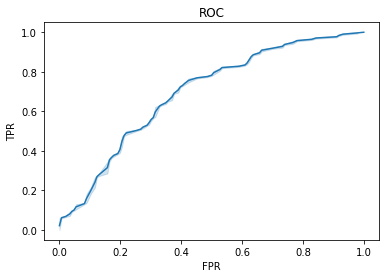

In [33]:
# Autoencoder dataset regression and AUC plot / calculation
Q3_AutoEncoder = autoencoder(n_neurons = 60)
X_scaled = torch.from_numpy(TfIDF_train).float()
max_iter = 5000

for t in range(max_iter):
    y_pred = Q2_AutoEncoder(X_scaled)
    loss = loss_fn(y_pred, X_scaled)
    Q3_AutoEncoder.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in Q2_AutoEncoder.parameters():
            param -= learning_rate * param.grad 
            
            
X_train_encoder = Q3_AutoEncoder.encoder(torch.from_numpy(TfIDF_train).float()).detach().numpy()
X_test_encoder = Q3_AutoEncoder.encoder(torch.from_numpy(TfIDF_test).float()).detach().numpy()

Q3_model_encoder = LogisticRegressionCV(cv=5, max_iter = 10000)
Q3_model_encoder.fit(X_train_encoder, y_train)

Q3_ytest_prob_encoder = Q3_model_encoder.predict_proba(X_test_encoder)
Q3_ytest_prob_encoder = Q3_ytest_prob_encoder[:, 1] 
fpr, tpr, _ = roc_curve(y_test, Q3_ytest_prob_encoder)

ax = sns.lineplot(x=fpr,y=tpr)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("ROC")

roc_auc_score(y_test, Q3_ytest_prob_encoder)

**Written answer:**1.the larger AUROC the better the performace, the original TfIDF is the best 